## MNIST Data Set

The MNIST data set consists of $70000$ images of hand written digits, $60000$ of which are typically used as labeled training examples, where the other $10000$ are used for testing your learning model on. The following picture represent a sample of some of the images.

<img src="MnistExamples.png" alt="Drawing" style="width: 500px;"/>


To access this data set, as well as view the data as an image, we will need the following packages:
 * MLDatasets [documentation](https://github.com/JuliaML/MLDatasets.jl)
 * Images, TestImages, ImageMagicIO [documentation](https://juliaimages.org/latest/)

In [1]:
using MLDatasets, Plots, Images, TestImages

"
train_x, train_y = Fashion_MNIST.traindata()
test_x,  test_y  = Fashion_MNIST.testdata()
"

train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata()

# Flatten the matrix input data into a vector
X = []   # Flattened 784 column vectors
Y = []   # One-hot encoding label vectors 
for i = 1:60000
    push!(X, reshape(train_x[:,:,i], 784))
    y = zeros(10)
    y[train_y[i] + 1] = 1.0
    push!(Y,y)
end
train_data = [x for x in zip(X, Y)];

# Flatten the matrix input data into a vector
X = []   # Flattened 784 column vectors
Y = []   # One-hot encoding label vectors 
for i = 1:10000
    push!(X, reshape(test_x[:,:,i], 784))
    y = zeros(10)
    y[test_y[i] + 1] = 1.0
    push!(Y,y)
end
test_data = [x for x in zip(X, Y)];

In [2]:
# Fun ways to visualize images
function show_training_img(i)
    colorview(Gray, train_x[:,:,i]')
end

function show_test_img(i)
    colorview(Gray, test_x[:,:,i]')
end

show_test_img (generic function with 1 method)

## Building the Network Architecture 
For our purposes, we will build a multilayered perceptron with $L$ layers, $784$ input notes, $L-2$ hidden layers of arbitrary size, and $10$ output nodes. 

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For $l = 2, \dots, L$, each layer $l$ in our network will have two phases, the preactivation phase $$z^l = W^la^{l-1} + b^l,$$ and postactivation phase $$a^l = \sigma(z^l).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $a^1 = x$, where $x$ is the current input data into our network. For our activation function, we will use the sigmoid function:

* Sigmoid Function
$$
\sigma(s) = \frac{1}{1+e^{-s}}.
$$

For our cost function, we will use the Mean Sqaure Error cost:
$$
C = C(W, b) = \frac{1}{2}\sum_{i=1}^n||a^i - y^i||^2.
$$

In [3]:
# Define sigmoid function
σ(v) = 1.0/(1.0 + exp(-v))

# Define the derivative of the sigmoid function
dσ(v) = σ(v)*(1.0 - σ(v))

# Define the cost of a given output
MSE(a, y) = (1/2)*sum((a[i] - y[i])^2 for i = 1:size(a)[1])

# Define the total cost of a dataset with respect to weights and bias
function total_MSE(W, b, labeled_data)
    cost = 0.0
    for i = 1:60000
        Z, A = forward_pass(W, b, labeled_data[i])
        cost += MSE(σ.(A[size(W)[1]]), labeled_data[i][2])
    end
    return cost/60000
end

total_MSE (generic function with 1 method)

In [4]:
# Define feedforward pass of the network 
function forward_pass(W, b, x)
    Z = [[0.0]]
    A = [x[1]]
    for i = 2:size(W)[1]
        push!(Z, W[i]*A[i-1] + b[i])
        push!(A, σ.(Z[i]))
    end
    return Z, A
end

# Define the predicted outcome of the network with a function
function predict(W, b, x)
    Z, A = forward_pass(W, b, x)
    return argmax(A[end])- 1
end

function random_train(W, b, data_set, labeled_data_set)
    i = rand(1:size(data_set)[1])
    println("Predicted Label: ", predict(W, b, data_set[i]))
    println("Actual Label: ", labeled_data_set[i])
    show_training_img(i)
end

function random_test(W, b, data_set, labeled_data_set)
    i = rand(1:size(data_set)[1])
    println("Predicted Label: ", predict(W, b, data_set[i]))
    println("Actual Label: ", labeled_data_set[i])
    show_test_img(i)
end

random_test (generic function with 1 method)

In [5]:
# Initialize your weights/bias according to a normalized distribution
# with mean = 0.0 and standard deviation 1.0
function initialize_weights(input_layer_size, hidden_layer_sizes, output_layer_size)
    W = [[0.0], randn(hidden_layer_sizes[1], input_layer_size)]
    b = [[0.0], randn(hidden_layer_sizes[1])]
    
    for i = 2:size(hidden_layer_sizes)[1]
        push!(W, randn(hidden_layer_sizes[i], hidden_layer_sizes[i-1]))
        push!(b, randn(hidden_layer_sizes[i]))
    end
    
    push!(W, randn(output_layer_size, hidden_layer_sizes[end]))
    push!(b, randn(output_layer_size))
    
    return W, b
end

initialize_weights (generic function with 1 method)

In [13]:
# Test your function
# In this example: input layer = 784x1 -> 70x1 -> 70x1 -> 10X1 = output layer
W_test, b_test = initialize_weights(784, [70, 70], 10);

In [14]:
size(W_test[3])

(70, 70)

In [15]:
function deltas(W, b, x) 
    Z, A = forward_pass(W, b, x)
    L = size(W)[1]
    δ = Dict()
    δ[L] = (A[end] - x[2]).*dσ.(Z[end])
    for i = L-1:-1:2
        δ[i] = (W[i+1]'*δ[i+1]).*dσ.(Z[i])
    end
    return A, δ
end

deltas (generic function with 1 method)

In [16]:
function stochastic_gradient_descent(W, b, data_set, batch_size, epochs, η; show_cost = false)
    W_new = copy(W)
    b_new = copy(b)
    L = size(W)[1]
    
    if show_cost == true
        cost_points = [(0, total_MSE(W_new, b_new, data_set))]

        for j = 1:epochs
            k = rand(1:size(data_set)[1]-batch_size)
            batch = data_set[k:k+batch_size]
            for x in batch
                A, δ = deltas(W_new, b_new, x)
                for i = L:-1:2
                    W_new[i] -= (η/batch_size)*δ[i]*A[i-1]'
                    b_new[i] -= (η/batch_size)*δ[i]
                end 
            end
        
        push!(cost_points, (j, total_MSE(W_new, b_new, data_set)))
        end
        n = η
        plot(cost_points, 
            xaxis = "Epochs", 
            yaxis = "Cost",
            title = "epochs = $epochs, batch size = $batch_size, eta = $n",
            legend = false)
        
        return W_new, b_new
    else
        for j = 1:epochs
            k = rand(1:size(data_set)[1]-batch_size)
            batch = data_set[k:k+batch_size]
            for x in batch
                A, δ = deltas(W_new, b_new, x)
                for i = L:-1:2
                    W_new[i] -= (η/batch_size)*δ[i]*A[i-1]'
                    b_new[i] -= (η/batch_size)*δ[i]
                end 
            end
        end

        return W_new, b_new
    end
end

stochastic_gradient_descent (generic function with 1 method)

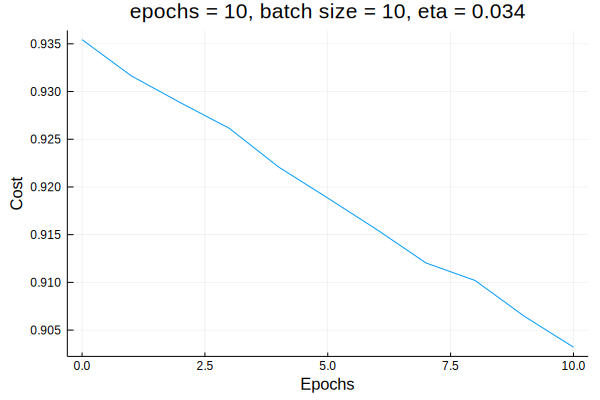

In [17]:
#W_test, b_test = initialize_weights(784, [16, 16], 10);
W1, b1 = stochastic_gradient_descent(W_test, b_test, train_data, 10, 10, 0.034, show_cost = true)
plot!()

In [18]:
W_test, b_test = stochastic_gradient_descent(W_test, b_test, train_data, 10, 10000, 0.034)

(Array{Float64,N} where N[[0.0], [-1.10678 -0.208785 … -0.265699 1.05262; 0.367155 1.38703 … -1.34925 -0.153466; … ; 0.362381 1.13216 … 0.708254 1.2214; 1.76521 0.256655 … -1.49912 0.505509], [-0.467135 0.0318516 … -1.59685 1.0484; -2.12686 -2.62 … 0.919929 -1.66145; … ; -0.455269 0.126434 … 0.765331 -0.574931; -0.522508 0.505345 … 1.69809 0.805096], [-0.235703 -0.27935 … 0.108164 0.823634; -1.23602 -2.13895 … 1.44867 3.02053; … ; -0.972112 1.63371 … -1.1949 -1.27092; -2.02894 -0.0764903 … 0.0298351 1.14767]], Array{Float64,1}[[0.0], [1.63449, 0.579161, 0.21512, -1.22728, -1.03684, -1.21082, -1.0887, 0.938526, -0.941319, -0.962461  …  -0.164518, -0.770526, -0.43102, -1.05542, -0.254865, 0.698335, 0.103096, 1.54021, -1.38329, -0.901982], [0.79321, -0.330253, 1.3305, -1.83009, -0.968967, -1.06509, 0.174876, -1.22218, -0.83511, 0.437246  …  0.190026, 0.0615159, 1.101, -0.0777612, 0.513107, 0.0614134, 0.954297, -0.170625, 1.77917, -0.497908], [0.0156842, 0.661219, -0.886774, -0.307571, -2.

Predicted Label: 4
Actual Label: 9


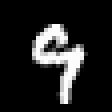

In [24]:
random_test(W_test, b_test, test_data, test_y)

In [25]:
W_test, b_test = stochastic_gradient_descent(W_test, b_test, train_data, 10, 10000, 0.034)

(Array{Float64,N} where N[[0.0], [-1.10678 -0.208785 … -0.265699 1.05262; 0.367155 1.38703 … -1.34925 -0.153466; … ; 0.362381 1.13216 … 0.708254 1.2214; 1.76521 0.256655 … -1.49912 0.505509], [-0.43816 0.0392883 … -1.55236 1.09648; -2.14545 -2.6241 … 0.967922 -1.63241; … ; -0.457531 0.110064 … 0.740829 -0.585813; -0.505816 0.515259 … 1.7044 0.817605], [-0.272487 -0.310364 … 0.0955989 0.787672; -1.2201 -2.16713 … 1.44623 3.01517; … ; -0.928445 1.64803 … -1.15842 -1.22753; -1.98654 -0.0264947 … -0.127287 1.13627]], Array{Float64,1}[[0.0], [1.664, 0.59516, 0.181365, -1.27644, -1.02608, -1.23278, -1.07762, 0.928615, -0.922201, -0.915066  …  -0.162631, -0.786385, -0.437028, -1.11985, -0.253504, 0.729727, 0.0747574, 1.53321, -1.34084, -0.87157], [0.851705, -0.302332, 1.32635, -1.87996, -0.973172, -1.0764, 0.173488, -1.23129, -0.757954, 0.463455  …  0.191615, 0.0752248, 1.13635, -0.0934934, 0.509552, 0.0565811, 0.958039, -0.180078, 1.77055, -0.477692], [-0.0209008, 0.66392, -0.878539, -0.3183

Predicted Label: 6
Actual Label: 6


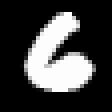

In [36]:
random_test(W_test, b_test, test_data, test_y)

In [57]:
W_test, b_test = stochastic_gradient_descent(W_test, b_test, train_data, 10, 20000, 0.034)

(Array{Float64,N} where N[[0.0], [-1.10678 -0.208785 … -0.265699 1.05262; 0.367155 1.38703 … -1.34925 -0.153466; … ; 0.362381 1.13216 … 0.708254 1.2214; 1.76521 0.256655 … -1.49912 0.505509], [-0.409712 0.0427446 … -1.49092 1.1549; -2.13971 -2.65272 … 1.02242 -1.57065; … ; -0.409516 0.0376558 … 0.61568 -0.58356; -0.494065 0.514924 … 1.70598 0.829024], [-0.289389 -0.324939 … 0.105484 0.771974; -1.23856 -2.28144 … 1.38331 2.98943; … ; -1.01305 1.48794 … -0.821654 -1.29742; -2.05374 -0.0292883 … -0.369781 1.03823]], Array{Float64,1}[[0.0], [1.75555, 0.635979, 0.174389, -1.34407, -1.0021, -1.25246, -1.09142, 0.91486, -0.943036, -0.791102  …  -0.224207, -0.772138, -0.407571, -1.22471, -0.240973, 0.684764, 0.0178948, 1.55306, -1.30868, -0.862176], [0.929898, -0.250058, 1.28393, -2.00949, -0.998335, -0.891773, 0.182121, -1.19088, -0.817463, 0.450984  …  0.139741, 0.133926, 1.2388, -0.11975, 0.481687, 0.0704932, 0.922186, -0.228332, 1.79221, -0.452904], [-0.037605, 0.642251, -0.817067, -0.3697

Predicted Label: 8
Actual Label: 5


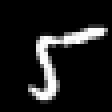

In [56]:
random_test(W_test, b_test, test_data, test_y)